# Introduction 
This project consists in analysing the last 30 years measured wind in Dublin and the possible relationship to the climate change using the synoptic station in Dublin_Airport, Co Dublin. 
Source: https://data.gov.ie/dataset/dublin-airport-hourly-data

### 1. Data Loading and Preparation

In [2]:

# import pandas to use DataFrames
import pandas as pd

# import matplotlib to plot data representations
import matplotlib.pyplot as plt

# import seaborn to plot heatmaps
import seaborn as sns

# import numpy to use mathematical functions
import numpy as np



The first 23 lines of the source CSV contains non-csv metadata, that give some context on the database. 

In [3]:
# Read the first 23 lines of the CSV as text to display the metadata
with open("wind.csv", "r") as file:
    for i in range(23):
        print(file.readline().rstrip())

Station Name: DUBLIN AIRPORT
Station Height: 71 M
Latitude:53.428  ,Longitude: -6.241


date:  -  Date and Time (utc)
rain:  -  Precipitation Amount (mm)
temp:  -  Air Temperature (C)
wetb:  -  Wet Bulb Temperature (C)
dewpt: -  Dew Point Temperature (C)
rhum:  -  Relative Humidity (%)
vappr: -  Vapour Pressure (hPa)
msl:   -  Mean Sea Level Pressure (hPa)
wdsp:  -  Mean Wind Speed (knot)
wddir: -  Predominant Wind Direction (degree)
ww:    -  Synop code for Present Weather
w:     -  Synop code for Past Weather
sun:   -  Sunshine duration (hours)
vis:   -  Visibility (m)
clht:  -  Cloud height (100's of ft) - 999 if none
clamt: -  Cloud amount
ind:   -  Indicator



### Variable Descriptions and Climate Change Analysis

Some of the available variables are useful for wind and climate change analysis, while others can be discarded. They can be categorized as follows:

#### Core Climate Variables

- **date**: Date and Time (UTC) - Temporal reference for all measurements, essential for trend analysis.
- **temp**: Air Temperature (°C) - Direct indicator of climate change; warming trends are a primary climate change signal.
- **rain**: Precipitation Amount (mm) - Important for understanding changes in precipitation patterns, intensity, and frequency related to climate change.
- **msl**: Mean Sea Level Pressure (hPa) - Reflects atmospheric circulation patterns; changes can indicate shifts in weather systems and storm tracks.
- **rhum**: Relative Humidity (%) - Measures atmospheric moisture content; important for understanding changes in water vapor (a key greenhouse gas feedback).
- **wdsp**: Mean Wind Speed (knots) - Wind patterns can shift with climate change and is also our main target of analysis.
- **wddir**: Predominant Wind Direction (degrees) - Can reveal shifts in prevailing wind patterns and atmospheric circulation regimes.

#### Atmospheric Moisture Variables:

- **dewpt**: Dew Point Temperature (°C) - Indicates absolute atmospheric moisture content; useful for understanding humidity changes over time
- **vappr**: Vapour Pressure (hPa) - Direct measure of atmospheric water vapor; important for understanding the hydrological cycle and greenhouse effect
- **wetb**: Wet Bulb Temperature (°C) - Derived from temperature and humidity; useful for heat stress analysis but less direct for climate trends

#### Solar Radiation Variable

- **sun**: Sunshine Duration (hours) - Related to solar radiation and cloud cover; can indicate changes in cloudiness patterns and solar energy availability

#### Weather Classification Variables

- **ww**: Synop Code for Present Weather - Categorical weather classification; less useful for quantitative climate trend analysis
- **w**: Synop Code for Past Weather - Historical weather classification; limited value for long-term climate analysis

Source: https://share.google/aimode/kygrfjkFQxoGu4PfZ

#### Atmospheric Visibility and Cloud Variables

- **vis**: Visibility (m) - Affected by fog, pollution, and precipitation; can indicate changes in air quality and atmospheric conditions
- **clht**: Cloud Height (100's of ft, 999 if none) - Cloud vertical structure; useful for understanding cloud cover changes
- **clamt**: Cloud Amount - Cloud coverage; important for understanding changes in cloudiness which affects radiation balance

#### Technical Variables

- **ind**: Indicator - Data quality flags or measurement indicators; not directly useful for climate analysis

### Ideal Variables for Multi-Variable Climate Change Analysis

- `temp` (Air Temperature) - Core climate indicator
- `rain` (Precipitation) - Hydrological cycle changes
- `wdsp` and `wddir` (Wind Speed and Wind Direction) - Wind measures
- `msl` (Mean Sea Level Pressure) - Atmospheric circulation
- `rhum` (Relative Humidity) - Greenhouse gas feedback

#### Analysis Approach
- Analyze wind patterns alone, in the last 30 years
- Correlate temperature trends with wind speed, precipitation, and pressure patterns
- Analyze relationships between humidity, temperature, and precipitation
- Examine pressure-wind relationships to understand circulation changes
- Investigate seasonal shifts in multiple variables simultaneously

### 1.1 Load and Clean Data

We will select only the columns that are directly related to wind speed and its climatic interpretation, renaming them to have understandable names.
And delete the columns we don't need for the aim of this analysis.

Filter the period required, 30 years, from 1995 to 2025, so we can ignore the years prior to this period.

As the dataset mesures the wind speed in knots. To follow the international standard, we change it to meters per second (m/s).

Source: https://share.google/aimode/Py9CUXm0ByMYwoZGp

In [4]:
# Load the dataset and prepare for analysis
df = pd.read_csv("wind.csv", skiprows=23, low_memory=False)

# Rename key columns
df = df.rename(columns={
    'date': 'date and time', 
    'temp': 'air temperature', 
    'wdsp': 'mean wind speed', 
    'wddir': 'wind direction',
    'msl': 'mean sea level pressure',
    'rhum': 'relative humidity',
    'rain': 'precipitation'
})

# Remove indicator columns and unused variables
df = df.loc[:, ~df.columns.str.startswith('ind')]
df = df.drop(columns=['wetb', 'dewpt', 'vappr', 'w', 'ww', 'vis', 'clht', 'clamt', 'sun'], errors='ignore')

# Convert date to datetime and set as index
df['date and time'] = pd.to_datetime(df['date and time'], format='%d-%b-%Y %H:%M')
df.set_index('date and time', inplace=True)
df = df.sort_index()

# Filter to 1995-2025 - remove ALL data before 1995-01-01
df = df[(df.index >= '1995-01-01') & (df.index <= '2025-12-31')]

# Convert wind speed from knots to m/s to adhere to the International System of Units
df['mean wind speed'] = df['mean wind speed'] * 0.514444

# Convert object columns to numeric where needed
for col in ['relative humidity', 'wind direction']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 271729 entries, 1995-01-01 00:00:00 to 2025-12-31 00:00:00
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   precipitation            271729 non-null  float64
 1   air temperature          271729 non-null  float64
 2   relative humidity        271728 non-null  float64
 3   mean sea level pressure  271729 non-null  float64
 4   mean wind speed          271729 non-null  float64
 5   wind direction           271728 non-null  float64
dtypes: float64(6)
memory usage: 14.5 MB


In [6]:
# Display the first rows to get a clue of the data
df.head()

,precipitation,air temperature,relative humidity,mean sea level pressure,mean wind speed,wind direction
date and time,,,,,,
1995-01-01 00:00:00,0.0,-0.7,98.0,1012.3,5.658884,280.0
1995-01-01 01:00:00,0.0,-0.8,98.0,1012.7,5.658884,280.0
1995-01-01 02:00:00,0.0,-1.2,100.0,1013.7,5.658884,280.0
1995-01-01 03:00:00,0.0,-1.3,100.0,1013.9,4.629996,270.0
1995-01-01 04:00:00,0.0,-0.5,100.0,1014.1,5.144440,270.0


In [7]:
df.tail()

,precipitation,air temperature,relative humidity,mean sea level pressure,mean wind speed,wind direction
date and time,,,,,,
2025-12-30 20:00:00,0.0,4.6,79.0,1037.0,2.572220,90.0
2025-12-30 21:00:00,0.0,2.4,86.0,1036.9,2.057776,50.0
2025-12-30 22:00:00,0.0,0.5,88.0,1036.9,2.057776,10.0
2025-12-30 23:00:00,0.0,0.1,90.0,1037.0,2.057776,20.0
2025-12-31 00:00:00,0.0,1.5,91.0,1037.0,1.543332,290.0


## 2. Wind Speed Analysis

### 2.1 Annual and Seasonal Trends

Wind Speed Trend: -0.0224 m/s per year (-0.22 m/s per decade)

Decade Averages:
  1995-2004: 5.34 m/s
  2005-2014: 5.57 m/s
  2015-2024: 5.02 m/s
  Change (1995-2004 to 2015-2024): -6.13%


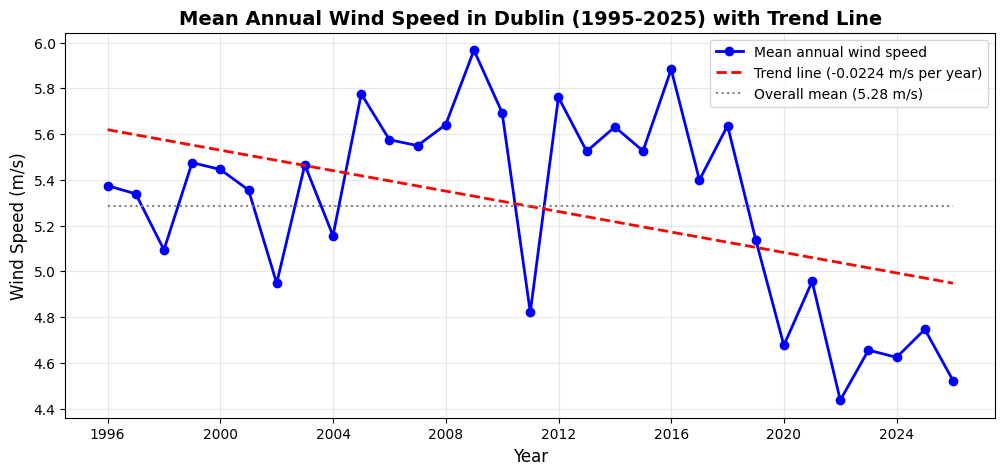

In [8]:
# We use Resample() for time series analysis: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html
# Calculate annual and seasonal statistics
'''Y is deprecated, use YE instead'''
df_yearly = df.resample('YE')['mean wind speed'].mean()
df_yearly_max = df.resample('YE')['mean wind speed'].max()

# Calculate trend using linear regression
# Convert dates to numeric years for regression
years = df_yearly.index.year.values.astype(float)
wind_speeds = df_yearly.values

# Calculate linear regression
slope, intercept = np.polyfit(years, wind_speeds, 1)
trend = slope  # m/s per year
trend_decade = trend * 10  # m/s per decade

# Create trend line for plotting
trend_line = slope * years + intercept

# Decade comparison
decade1 = df.loc['1995-01-01':'2004-12-31']['mean wind speed'].mean()
decade2 = df.loc['2005-01-01':'2014-12-31']['mean wind speed'].mean()
decade3 = df.loc['2015-01-01':'2024-12-31']['mean wind speed'].mean()

print(f"Wind Speed Trend: {trend:.4f} m/s per year ({trend_decade:.2f} m/s per decade)")
print(f"\nDecade Averages:")
print(f"  1995-2004: {decade1:.2f} m/s")
print(f"  2005-2014: {decade2:.2f} m/s")
print(f"  2015-2024: {decade3:.2f} m/s")
print(f"  Change (1995-2004 to 2015-2024): {((decade3 - decade1) / decade1 * 100):.2f}%")

# Plot annual wind speed with trend line
plt.figure(figsize=(12, 5))
plt.plot(df_yearly.index, df_yearly.values, 'o-', label='Mean annual wind speed', linewidth=2, markersize=6, color='blue')
plt.plot(df_yearly.index, trend_line, '--', label=f'Trend line ({trend:.4f} m/s per year)', linewidth=2, color='red')
mean_wind = df_yearly.mean()
plt.hlines(mean_wind, df_yearly.index.min(), df_yearly.index.max(),
           linestyles=':', color='gray', label=f'Overall mean ({mean_wind:.2f} m/s)')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Wind Speed (m/s)', fontsize=12)
plt.title('Mean Annual Wind Speed in Dublin (1995-2025) with Trend Line', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

### 2.2 Seasonal Patterns

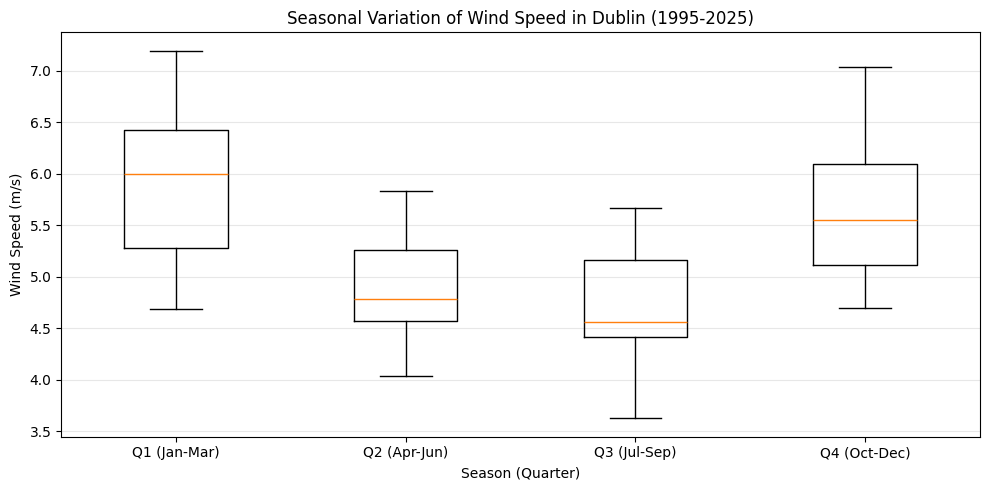

Q1 (Winter): median = 5.99 m/s
Q2 (Spring): median = 4.78 m/s
Q3 (Summer): median = 4.56 m/s
Q4 (Autumn): median = 5.55 m/s


In [9]:
# Seasonal analysis
''' Q is deprecated, use QE instead'''
df_seasonal = df.resample('QE')['mean wind speed'].mean()

windspeed_df = df_seasonal.reset_index()
windspeed_df['quarter'] = windspeed_df['date and time'].dt.quarter

# Boxplot by quarter
data_by_quarter = [windspeed_df[windspeed_df['quarter'] == q]['mean wind speed'].values 
                   for q in [1, 2, 3, 4]]

plt.figure(figsize=(10, 5))
plt.boxplot(data_by_quarter, tick_labels=['Q1 (Jan-Mar)', 'Q2 (Apr-Jun)', 'Q3 (Jul-Sep)', 'Q4 (Oct-Dec)'])
plt.xlabel("Season (Quarter)")
plt.ylabel("Wind Speed (m/s)")
plt.title("Seasonal Variation of Wind Speed in Dublin (1995-2025)")
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print seasonal medians
for q, label in [(1, 'Q1 (Winter)'), (2, 'Q2 (Spring)'), (3, 'Q3 (Summer)'), (4, 'Q4 (Autumn)')]:
    median_val = np.median(windspeed_df[windspeed_df['quarter'] == q]['mean wind speed'])
    print(f"{label}: median = {median_val:.2f} m/s")

The height of the boxes (IQR) indicates:

- Greater variability in winter and autumn

- More storms and fronts

- Less variability in summer

- More stable conditions


The whiskers indicates:

- Q1 and Q4 reach maximums close to 7–7.2 m/s.

- Q3 has lower minimums (3.6–3.7 m/s).

Interpretation:

Strong wind events are concentrated in cold months.

Calm conditions predominate in summer.

### 2.3 Extreme Wind Events

Extreme wind level (95th percentile): 10.29 m/s
Average extreme events per year: 529

Storm events (≥20.8 m/s) per year: 0.35
Wind Storm events (≥17.2 m/s) per year: 4.06


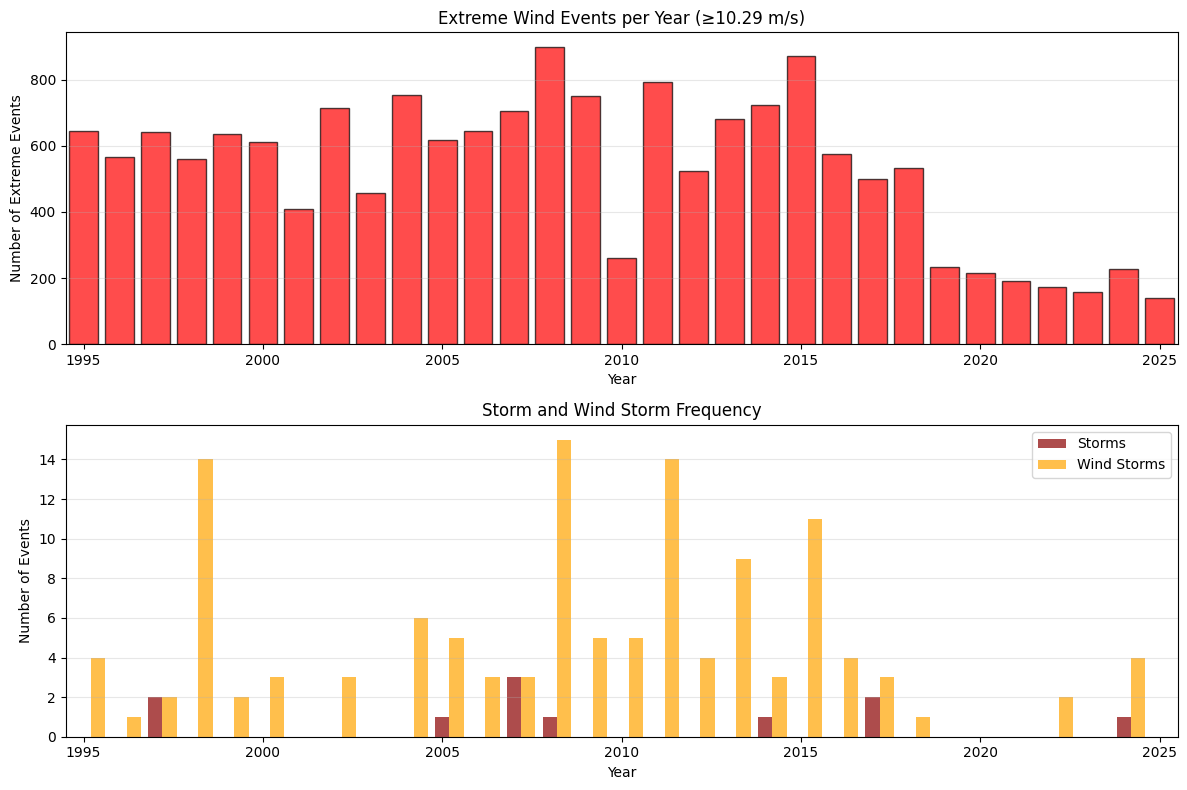

In [10]:
# Extreme wind events analysis
extreme_level = df['mean wind speed'].quantile(0.95)
df['extreme_wind'] = df['mean wind speed'] >= extreme_level
extreme_by_year = df.groupby(df.index.year)['extreme_wind'].sum()

# Storm and wind·storm analysis
storm_level = 20.8  # m/s (Force 9)
wind_storm_level = 17.2   # m/s (Force 8)
df['storm'] = df['mean wind speed'] >= storm_level
df['gale'] = (df['mean wind speed'] >= wind_storm_level) & (df['mean wind speed'] < storm_level)
storms_by_year = df.groupby(df.index.year)['storm'].sum()
wind_storms_by_year = df.groupby(df.index.year)['gale'].sum()

print(f"Extreme wind level (95th percentile): {extreme_level:.2f} m/s")
print(f"Average extreme events per year: {extreme_by_year.mean():.0f}")
print(f"\nStorm events (≥{storm_level} m/s) per year: {storms_by_year.mean():.2f}")
print(f"Wind Storm events (≥{wind_storm_level} m/s) per year: {wind_storms_by_year.mean():.2f}")

# Visualize extreme events
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot extreme events - use explicit bar plot with year index
ax1.bar(extreme_by_year.index, extreme_by_year.values, color='red', alpha=0.7, edgecolor='black')
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of Extreme Events")
ax1.set_title(f"Extreme Wind Events per Year (≥{extreme_level:.2f} m/s)")
ax1.grid(True, axis='y', alpha=0.3)
ax1.set_xlim(left=extreme_by_year.index.min() - 0.5, right=extreme_by_year.index.max() + 0.5)

ax2.bar(storms_by_year.index, storms_by_year.values, color='darkred', alpha=0.7, label='Storms', width=0.4)
ax2.bar(wind_storms_by_year.index + 0.4, wind_storms_by_year.values, color='orange', alpha=0.7, label='Wind Storms', width=0.4)
ax2.set_xlabel("Year")
ax2.set_ylabel("Number of Events")
ax2.set_title("Storm and Wind Storm Frequency")
ax2.legend()
ax2.grid(True, axis='y', alpha=0.3)
ax2.set_xlim(left=storms_by_year.index.min() - 0.5, right=wind_storms_by_year.index.max() + 0.5)

plt.tight_layout()
plt.show()

## 3. Multivariate Climate Analysis

This section analyzes relationships between multiple climate variables to better understand climate change patterns.

### 3.1 Temperature Trends

=== TEMPERATURE ANALYSIS ===
Temperature trend: 0.0201 °C per year (0.20 °C per decade)
Mean temperature (1995-2004): 9.74 °C
Mean temperature (2015-2024): 10.05 °C
Change: 3.22% (0.31 °C)


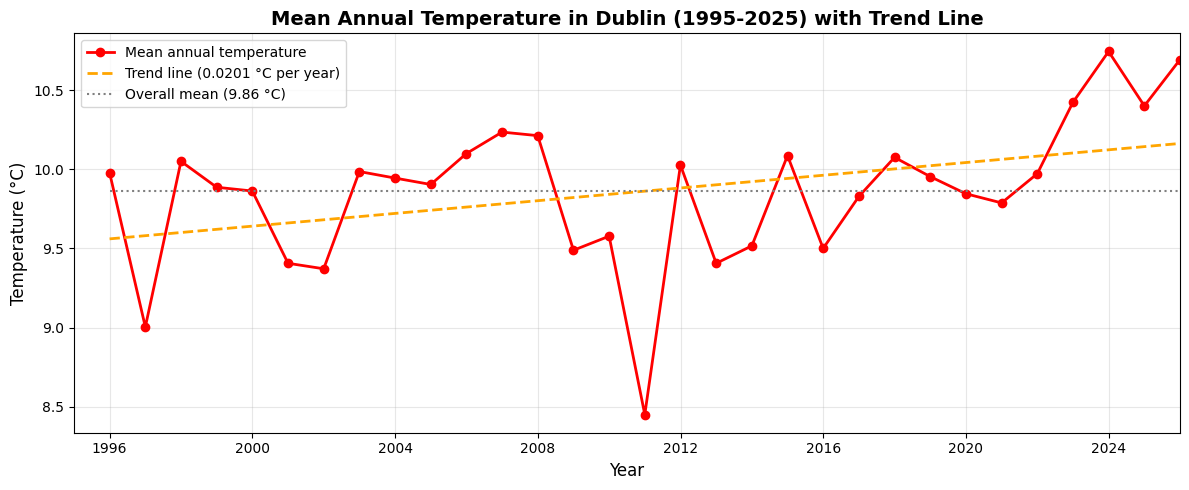

In [11]:
# Calculate annual temperature statistics
temp_yearly = df.resample('YE')['air temperature'].mean()

# Calculate trend using linear regression
# Convert dates to numeric years for regression
temp_years = temp_yearly.index.year.values.astype(float)
temp_values = temp_yearly.values

# Calculate linear regression
temp_line, temp_intercept = np.polyfit(temp_years, temp_values, 1)
temp_trend = temp_line  # °C per year
temp_trend_decade = temp_trend * 10  # °C per decade

# Create trend line for plotting
temp_trend_line = temp_line * temp_years + temp_intercept

temp_decade1 = df.loc['1995-01-01':'2004-12-31']['air temperature'].mean()
temp_decade3 = df.loc['2015-01-01':'2024-12-31']['air temperature'].mean()

print("=== TEMPERATURE ANALYSIS ===")
print(f"Temperature trend: {temp_trend:.4f} °C per year ({temp_trend_decade:.2f} °C per decade)")
print(f"Mean temperature (1995-2004): {temp_decade1:.2f} °C")
print(f"Mean temperature (2015-2024): {temp_decade3:.2f} °C")
print(f"Change: {((temp_decade3 - temp_decade1) / temp_decade1 * 100):.2f}% ({temp_decade3 - temp_decade1:.2f} °C)")

# Plot temperature trend
plt.figure(figsize=(12, 5))
plt.plot(temp_yearly.index, temp_yearly.values, 'o-', label='Mean annual temperature', linewidth=2, markersize=6, color='red')
plt.plot(temp_yearly.index, temp_trend_line, '--', label=f'Trend line ({temp_trend:.4f} °C per year)', linewidth=2, color='orange')
mean_temp = temp_yearly.mean()
plt.hlines(mean_temp, temp_yearly.index.min(), temp_yearly.index.max(),
           linestyles=':', color='gray', label=f"Overall mean ({mean_temp:.2f} °C)")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.title("Mean Annual Temperature in Dublin (1995-2025) with Trend Line", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xlim(left=pd.Timestamp('1995-01-01'), right=temp_yearly.index.max())
plt.show()

### 3.2 Precipitation Trends

=== PRECIPITATION ANALYSIS ===
Annual precipitation trend: 0.26 mm per year (2.64 mm per decade)
Mean annual precipitation (1995-2004): 769.5 mm
Mean annual precipitation (2015-2024): 760.8 mm
Change: -1.14% (-8.8 mm)


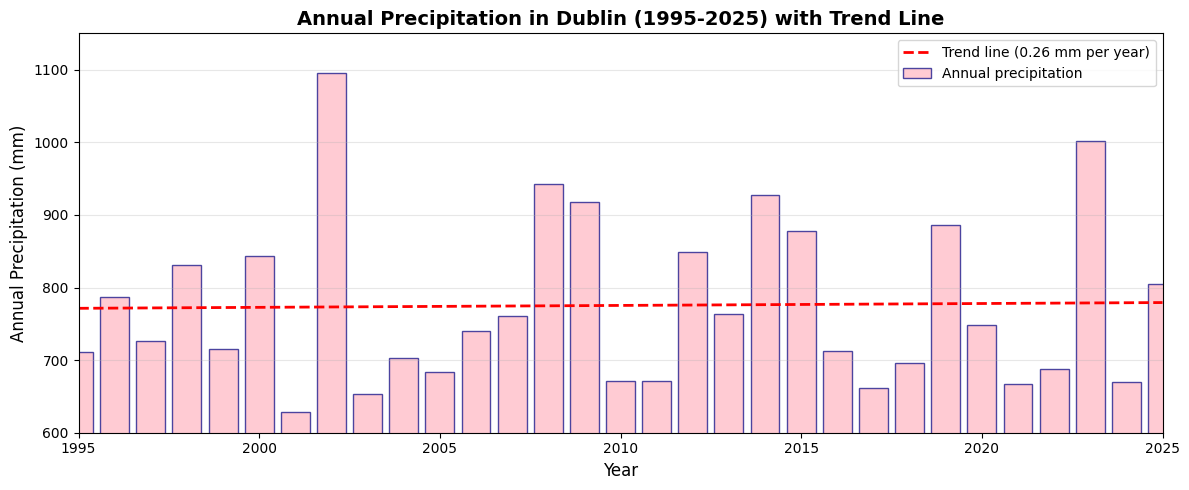

In [12]:
# Calculate annual precipitation statistics
rain_yearly = df.resample('YE')['precipitation'].sum()

# Calculate trend using linear regression
# Convert dates to numeric years for regression
rain_years = rain_yearly.index.year.values.astype(float)
rain_values = rain_yearly.values

# Calculate linear regression
rain_line, rain_intercept = np.polyfit(rain_years, rain_values, 1)
rain_trend = rain_line  # mm per year
rain_trend_decade = rain_trend * 10  # mm per decade

# Create trend line for plotting
rain_trend_line = rain_line * rain_years + rain_intercept

rain_decade1 = df.loc['1995-01-01':'2004-12-31']['precipitation'].sum() / 10
rain_decade3 = df.loc['2015-01-01':'2024-12-31']['precipitation'].sum() / 10

print("=== PRECIPITATION ANALYSIS ===")
print(f"Annual precipitation trend: {rain_trend:.2f} mm per year ({rain_trend_decade:.2f} mm per decade)")
print(f"Mean annual precipitation (1995-2004): {rain_decade1:.1f} mm")
print(f"Mean annual precipitation (2015-2024): {rain_decade3:.1f} mm")
print(f"Change: {((rain_decade3 - rain_decade1) / rain_decade1 * 100):.2f}% ({rain_decade3 - rain_decade1:.1f} mm)")

# Plot precipitation trend
plt.figure(figsize=(12, 5))
rain_years = rain_yearly.index.year
plt.bar(rain_years, rain_yearly.values, alpha=0.7, color='lightpink', edgecolor='navy', label='Annual precipitation')
plt.plot(rain_years, rain_trend_line, '--', label=f'Trend line ({rain_trend:.2f} mm per year)', linewidth=2, color='red')
mean_rain = rain_yearly.mean()
plt.xlabel("Year", fontsize=12)
plt.ylabel("Annual Precipitation (mm)", fontsize=12)
plt.title("Annual Precipitation in Dublin (1995-2025) with Trend Line", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, axis='y', alpha=0.3)
plt.xlim(left=rain_years.min(), right=rain_years.max())
plt.ylim(bottom=600)

plt.tight_layout()
plt.show()

### 3.3 Pressure and Humidity Analysis

In [13]:
# Calculate annual pressure and humidity statistics
msl_decade1 = df.loc['1995-01-01':'2004-12-31']['mean sea level pressure'].mean()
msl_decade3 = df.loc['2015-01-01':'2024-12-31']['mean sea level pressure'].mean()

print("=== MEAN SEA LEVEL PRESSURE ANALYSIS ===")
print(f"Mean pressure (1995-2004): {msl_decade1:.2f} hPa")
print(f"Mean pressure (2015-2024): {msl_decade3:.2f} hPa")
print(f"Change: {msl_decade3 - msl_decade1:.2f} hPa")

rhum_decade1 = df.loc['1995-01-01':'2004-12-31']['relative humidity'].mean()
rhum_decade3 = df.loc['2015-01-01':'2024-12-31']['relative humidity'].mean()

print("\n=== RELATIVE HUMIDITY ANALYSIS ===")
print(f"Mean humidity (1995-2004): {rhum_decade1:.1f}%")
print(f"Mean humidity (2015-2024): {rhum_decade3:.1f}%")
print(f"Change: {rhum_decade3 - rhum_decade1:.1f}%")

=== MEAN SEA LEVEL PRESSURE ANALYSIS ===
Mean pressure (1995-2004): 1013.43 hPa
Mean pressure (2015-2024): 1013.54 hPa
Change: 0.11 hPa

=== RELATIVE HUMIDITY ANALYSIS ===
Mean humidity (1995-2004): 84.5%
Mean humidity (2015-2024): 81.7%
Change: -2.8%


### 3.4 Correlation Analysis

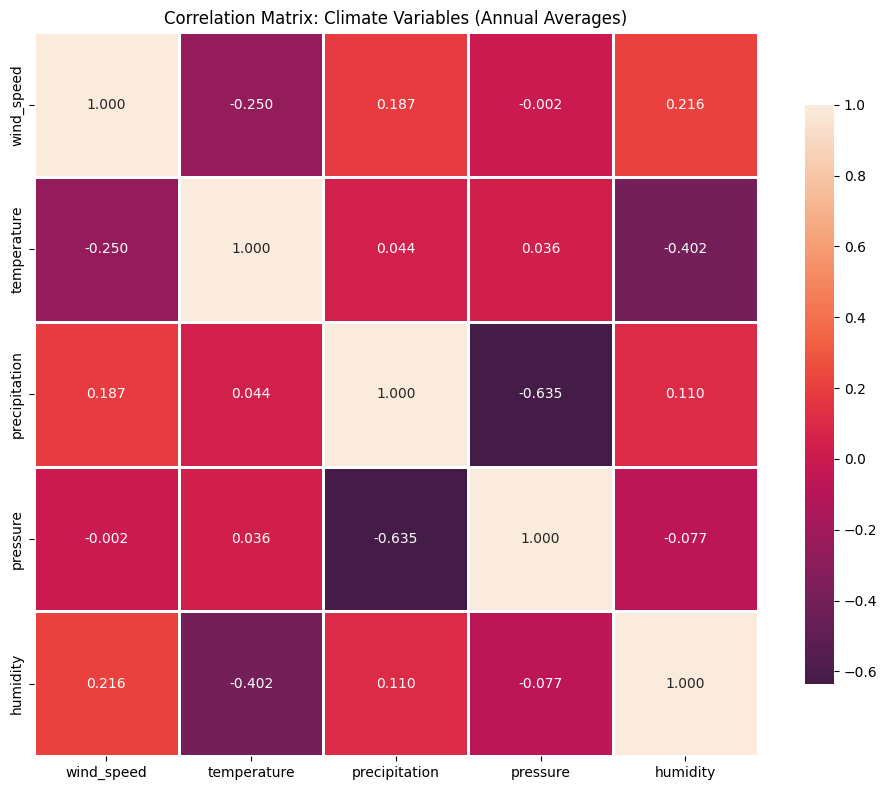

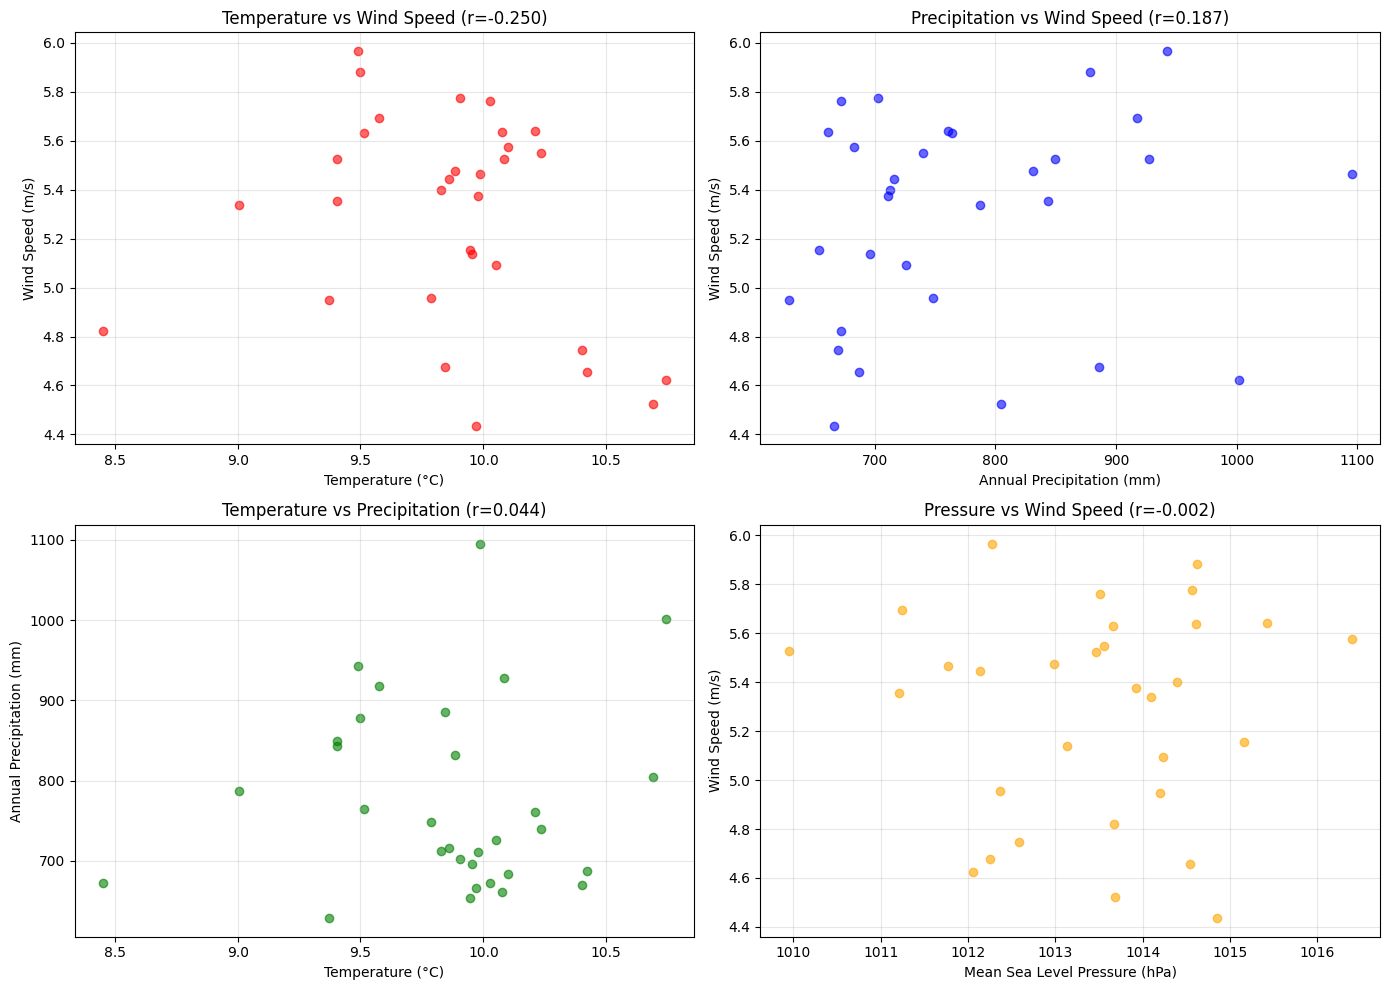

In [14]:
# Prepare annual data for correlation
annual_data = pd.DataFrame({
    'wind_speed': df_yearly,
    'temperature': temp_yearly,
    'precipitation': rain_yearly
})

msl_yearly = df.resample('YE')['mean sea level pressure'].mean()
annual_data['pressure'] = msl_yearly

rhum_yearly = df.resample('YE')['relative humidity'].mean()
annual_data['humidity'] = rhum_yearly

# Calculate correlation matrix
corr_matrix = annual_data.corr()

# Visualize correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='rocket', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix: Climate Variables (Annual Averages)")
plt.tight_layout()
plt.show()

# Scatter plots of key relationships
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Temperature vs Wind Speed
axes[0, 0].scatter(annual_data['temperature'], annual_data['wind_speed'], alpha=0.6, color='red')
axes[0, 0].set_xlabel('Temperature (°C)')
axes[0, 0].set_ylabel('Wind Speed (m/s)')
axes[0, 0].set_title(f'Temperature vs Wind Speed (r={corr_matrix.loc["temperature", "wind_speed"]:.3f})')
axes[0, 0].grid(True, alpha=0.3)

# Precipitation vs Wind Speed
axes[0, 1].scatter(annual_data['precipitation'], annual_data['wind_speed'], alpha=0.6, color='blue')
axes[0, 1].set_xlabel('Annual Precipitation (mm)')
axes[0, 1].set_ylabel('Wind Speed (m/s)')
axes[0, 1].set_title(f'Precipitation vs Wind Speed (r={corr_matrix.loc["precipitation", "wind_speed"]:.3f})')
axes[0, 1].grid(True, alpha=0.3)

# Temperature vs Precipitation
axes[1, 0].scatter(annual_data['temperature'], annual_data['precipitation'], alpha=0.6, color='green')
axes[1, 0].set_xlabel('Temperature (°C)')
axes[1, 0].set_ylabel('Annual Precipitation (mm)')
axes[1, 0].set_title(f'Temperature vs Precipitation (r={corr_matrix.loc["temperature", "precipitation"]:.3f})')
axes[1, 0].grid(True, alpha=0.3)

# Pressure vs Wind Speed
axes[1, 1].scatter(annual_data['pressure'], annual_data['wind_speed'], alpha=0.6, color='orange')
axes[1, 1].set_xlabel('Mean Sea Level Pressure (hPa)')
axes[1, 1].set_ylabel('Wind Speed (m/s)')
axes[1, 1].set_title(f'Pressure vs Wind Speed (r={corr_matrix.loc["pressure", "wind_speed"]:.3f})')
axes[1, 1].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()



QUARTER 1: Q1 (Winter: Jan-Mar)


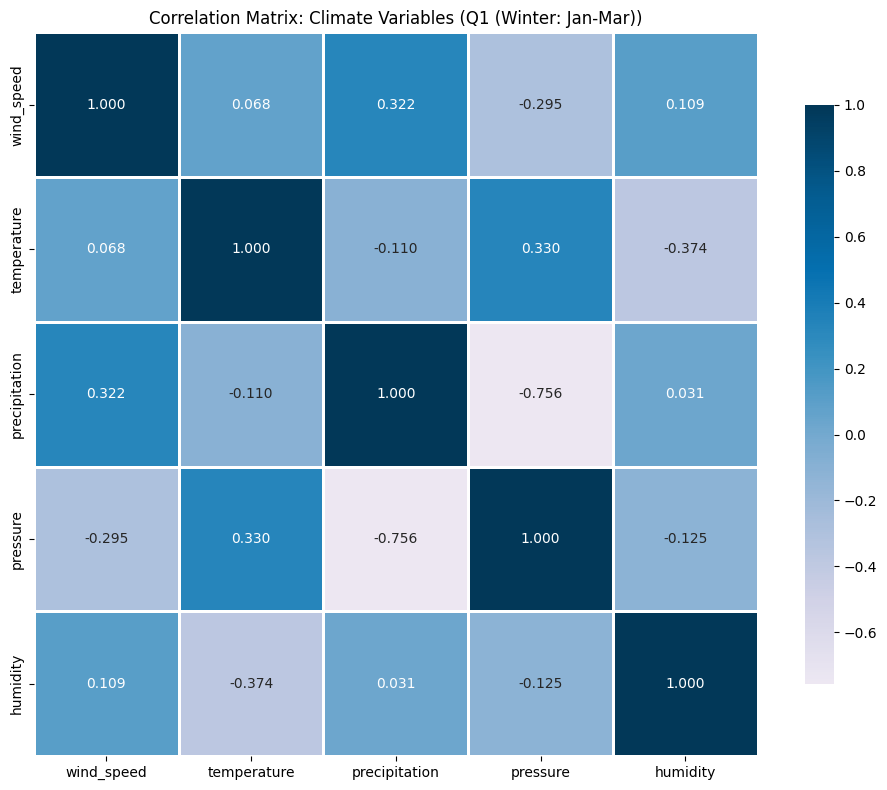


QUARTER 2: Q2 (Spring: Apr-Jun)


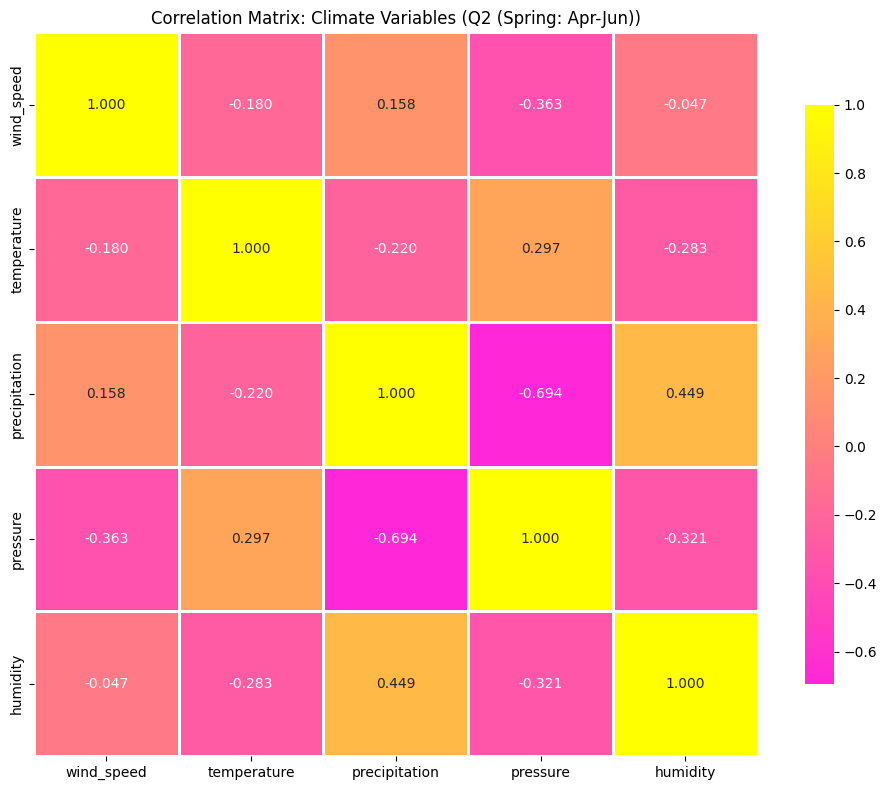


QUARTER 3: Q3 (Summer: Jul-Sep)


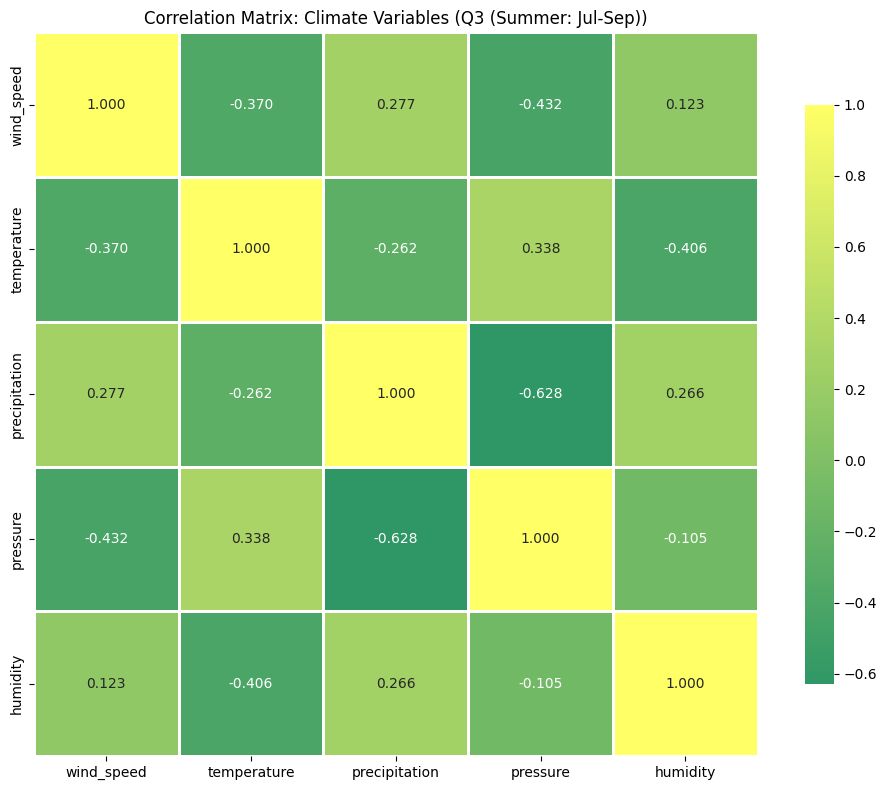


QUARTER 4: Q4 (Autumn: Oct-Dec)


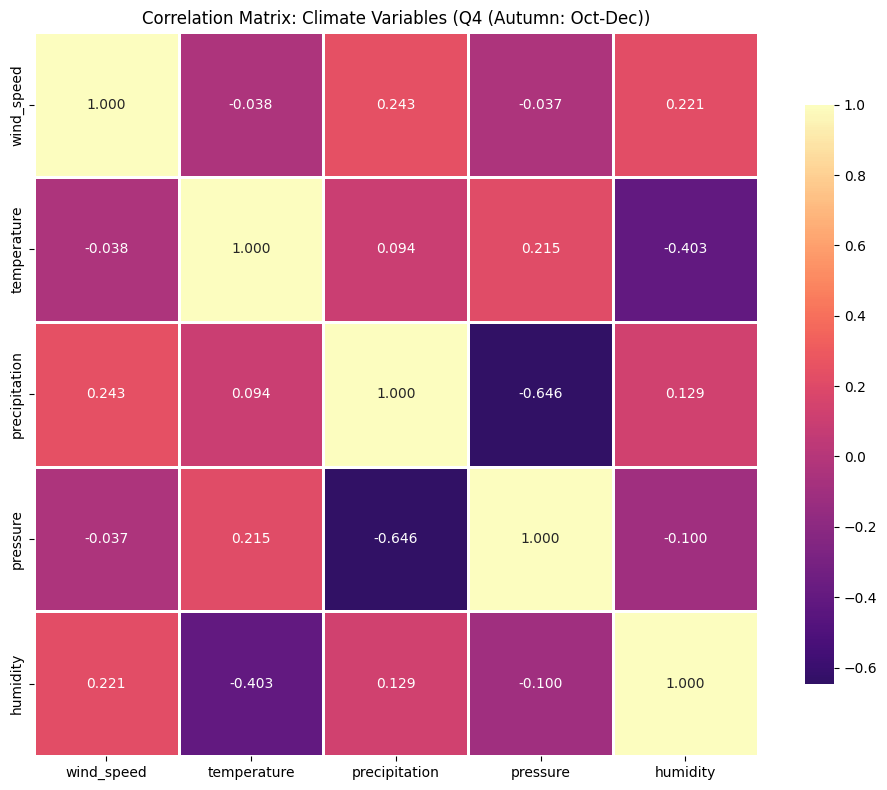

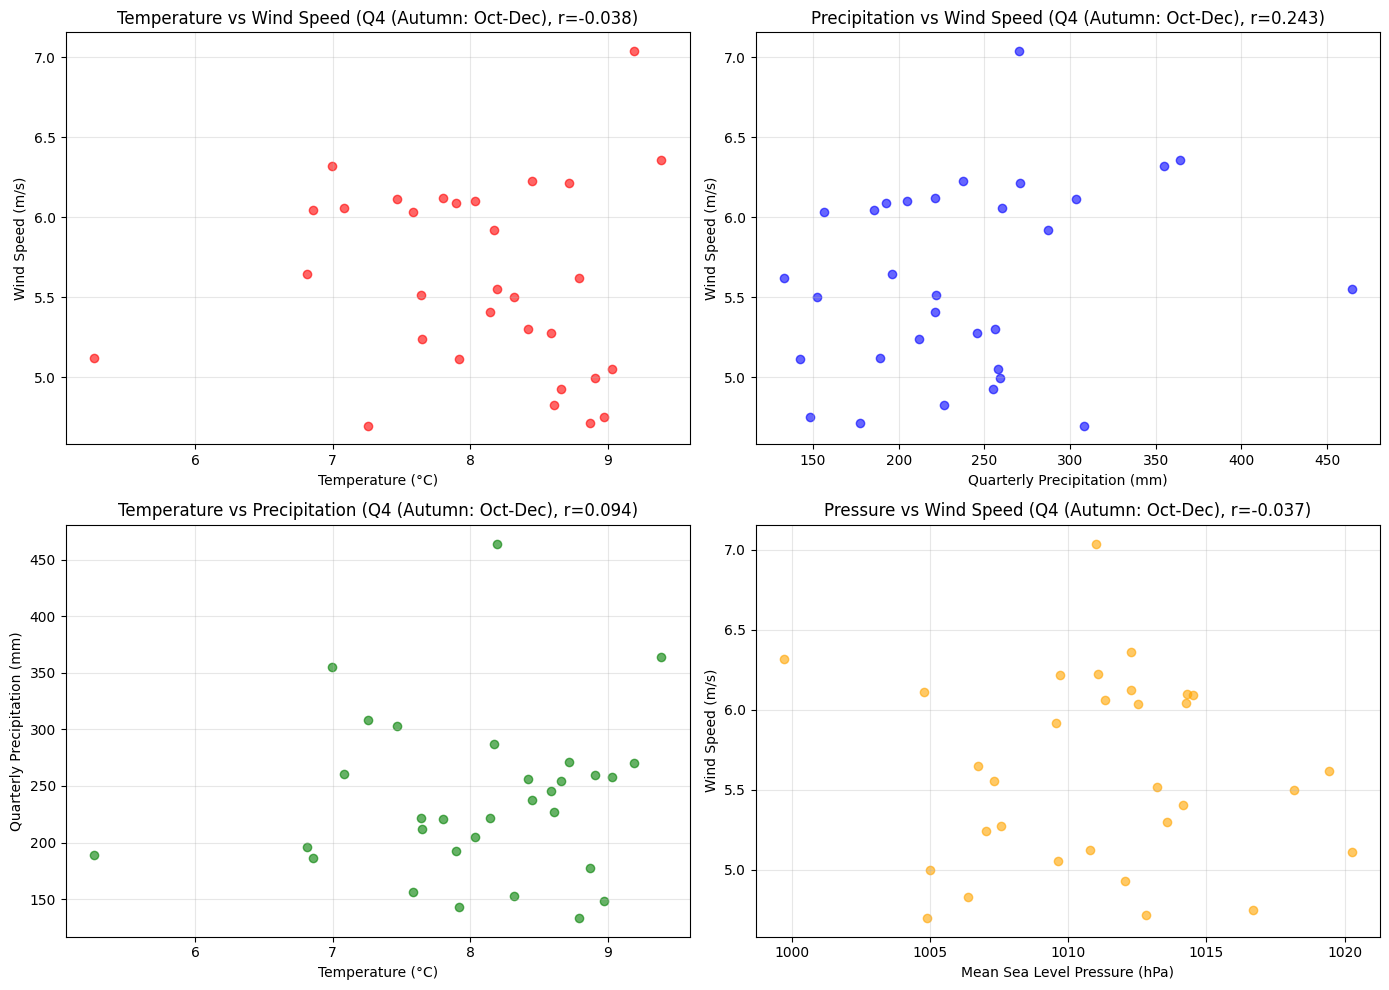


Correlation Matrix for Q4 (Autumn: Oct-Dec):
               wind_speed  temperature  precipitation  pressure  humidity
wind_speed       1.000000    -0.038145       0.243456 -0.037152  0.220665
temperature     -0.038145     1.000000       0.093934  0.214566 -0.403132
precipitation    0.243456     0.093934       1.000000 -0.646190  0.128987
pressure        -0.037152     0.214566      -0.646190  1.000000 -0.099652
humidity         0.220665    -0.403132       0.128987 -0.099652  1.000000


In [15]:
# Prepare seasonal (quarterly) data for correlation - split by quarter
quarter_labels = {1: 'Q1 (Winter: Jan-Mar)', 2: 'Q2 (Spring: Apr-Jun)', 
                  3: 'Q3 (Summer: Jul-Sep)', 4: 'Q4 (Autumn: Oct-Dec)'}

# Create quarterly dataframes
quarterly_data = {}
for quarter in [1, 2, 3, 4]:
    # Filter data for this quarter
    quarter_mask = df.index.quarter == quarter
    quarter_df = df[quarter_mask]
    
    # Resample to quarterly averages
    quarterly_data[quarter] = pd.DataFrame({
        'wind_speed': quarter_df.resample('QE')['mean wind speed'].mean(),
        'temperature': quarter_df.resample('QE')['air temperature'].mean(),
        'precipitation': quarter_df.resample('QE')['precipitation'].sum()  # Sum for quarterly totals
    })
    
    quarterly_data[quarter]['pressure'] = quarter_df.resample('QE')['mean sea level pressure'].mean()
    quarterly_data[quarter]['humidity'] = quarter_df.resample('QE')['relative humidity'].mean()

# Create correlation analysis for winter
for quarter in [1]:
    q_data = quarterly_data[quarter]
    q_corr_matrix = q_data.corr()
    
    print(f"\n{'='*60}")
    print(f"QUARTER {quarter}: {quarter_labels[quarter]}")
    print(f"{'='*60}")
    
    # Visualize correlation heatmap for this quarter
    plt.figure(figsize=(10, 8))
    sns.heatmap(q_corr_matrix, annot=True, fmt='.3f', cmap='PuBu', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title(f"Correlation Matrix: Climate Variables ({quarter_labels[quarter]})")
    plt.tight_layout()
    plt.show()

for quarter in [2]:
    q_data = quarterly_data[quarter]
    q_corr_matrix = q_data.corr()
    
    print(f"\n{'='*60}")
    print(f"QUARTER {quarter}: {quarter_labels[quarter]}")
    print(f"{'='*60}")
    
    # Visualize correlation heatmap for this quarter
    plt.figure(figsize=(10, 8))
    sns.heatmap(q_corr_matrix, annot=True, fmt='.3f', cmap='spring', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title(f"Correlation Matrix: Climate Variables ({quarter_labels[quarter]})")
    plt.tight_layout()
    plt.show()

for quarter in [3]:
    q_data = quarterly_data[quarter]
    q_corr_matrix = q_data.corr()
    
    print(f"\n{'='*60}")
    print(f"QUARTER {quarter}: {quarter_labels[quarter]}")
    print(f"{'='*60}")
    
    # Visualize correlation heatmap for this quarter
    plt.figure(figsize=(10, 8))
    sns.heatmap(q_corr_matrix, annot=True, fmt='.3f', cmap='summer', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title(f"Correlation Matrix: Climate Variables ({quarter_labels[quarter]})")
    plt.tight_layout()
    plt.show()

for quarter in [4]:
    q_data = quarterly_data[quarter]
    q_corr_matrix = q_data.corr()
    
    print(f"\n{'='*60}")
    print(f"QUARTER {quarter}: {quarter_labels[quarter]}")
    print(f"{'='*60}")
    
    # Visualize correlation heatmap for this quarter
    plt.figure(figsize=(10, 8))
    sns.heatmap(q_corr_matrix, annot=True, fmt='.3f', cmap='magma', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title(f"Correlation Matrix: Climate Variables ({quarter_labels[quarter]})")
    plt.tight_layout()
    plt.show()

# Scatter plots of key relationships for this quarter
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Temperature vs Wind Speed
    axes[0, 0].scatter(q_data['temperature'], q_data['wind_speed'], alpha=0.6, color='red')
    axes[0, 0].set_xlabel('Temperature (°C)')
    axes[0, 0].set_ylabel('Wind Speed (m/s)')
    axes[0, 0].set_title(f'Temperature vs Wind Speed ({quarter_labels[quarter]}, r={q_corr_matrix.loc["temperature", "wind_speed"]:.3f})')
    axes[0, 0].grid(True, alpha=0.3)

    # Precipitation vs Wind Speed
    axes[0, 1].scatter(q_data['precipitation'], q_data['wind_speed'], alpha=0.6, color='blue')
    axes[0, 1].set_xlabel('Quarterly Precipitation (mm)')
    axes[0, 1].set_ylabel('Wind Speed (m/s)')
    axes[0, 1].set_title(f'Precipitation vs Wind Speed ({quarter_labels[quarter]}, r={q_corr_matrix.loc["precipitation", "wind_speed"]:.3f})')
    axes[0, 1].grid(True, alpha=0.3)

    # Temperature vs Precipitation
    axes[1, 0].scatter(q_data['temperature'], q_data['precipitation'], alpha=0.6, color='green')
    axes[1, 0].set_xlabel('Temperature (°C)')
    axes[1, 0].set_ylabel('Quarterly Precipitation (mm)')
    axes[1, 0].set_title(f'Temperature vs Precipitation ({quarter_labels[quarter]}, r={q_corr_matrix.loc["temperature", "precipitation"]:.3f})')
    axes[1, 0].grid(True, alpha=0.3)

    # Pressure vs Wind Speed
    axes[1, 1].scatter(q_data['pressure'], q_data['wind_speed'], alpha=0.6, color='orange')
    axes[1, 1].set_xlabel('Mean Sea Level Pressure (hPa)')
    axes[1, 1].set_ylabel('Wind Speed (m/s)')
    axes[1, 1].set_title(f'Pressure vs Wind Speed ({quarter_labels[quarter]}, r={q_corr_matrix.loc["pressure", "wind_speed"]:.3f})')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print correlation matrix for this quarter
    print(f"\nCorrelation Matrix for {quarter_labels[quarter]}:")
    print(q_corr_matrix)
    


### 3.5 Combined Climate Trends Visualization


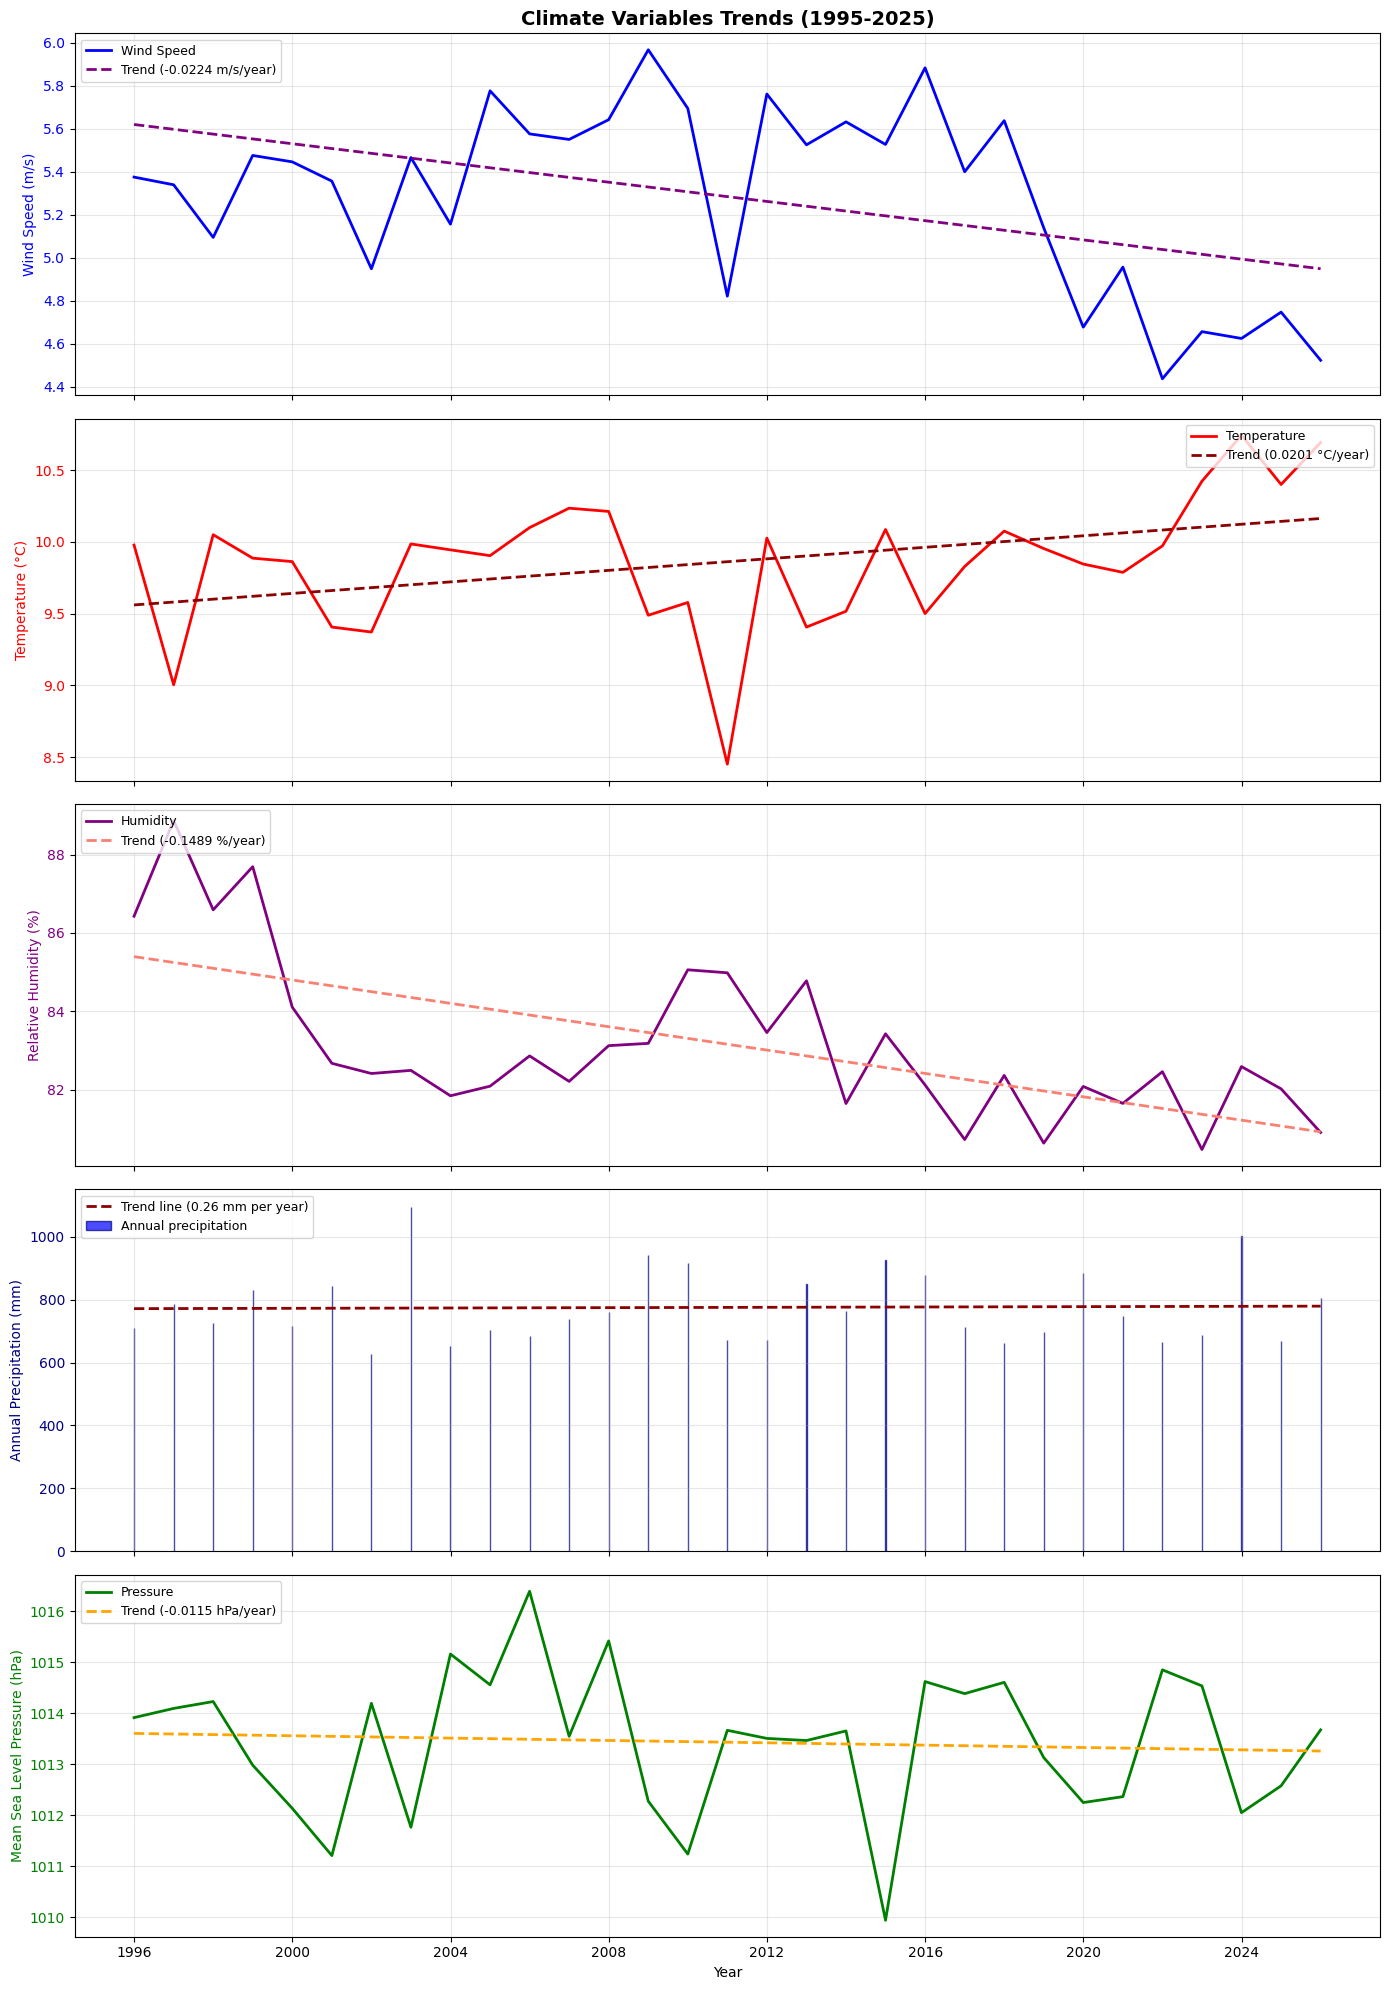

In [23]:
# Calculate trend lines for pressure and humidity using linear regression
msl_years = msl_yearly.index.year.values.astype(float)
msl_values = msl_yearly.values
msl_line, msl_intercept = np.polyfit(msl_years, msl_values, 1)
msl_trend_line = msl_line * msl_years + msl_intercept
msl_trend = msl_line
msl_trend_decade = msl_trend * 10

rhum_years = rhum_yearly.index.year.values.astype(float)
rhum_values = rhum_yearly.values
rhum_line, rhum_intercept = np.polyfit(rhum_years, rhum_values, 1)
rhum_trend_line = rhum_line * rhum_years + rhum_intercept
rhum_trend = rhum_line
rhum_trend_decade = rhum_trend * 10

# Create a comprehensive trends plot
fig, axes = plt.subplots(5, 1, figsize=(14, 20), sharex=True)
ax_index = -1

# Wind Speed
ax_index += 1
ax_wind = axes[ax_index]
ax_wind.plot(df_yearly.index, df_yearly.values, linewidth=2, color='blue', label='Wind Speed')
ax_wind.plot(df_yearly.index, trend_line, '--', linewidth=2, color='purple', label=f'Trend ({trend:.4f} m/s/year)')
ax_wind.set_ylabel('Wind Speed (m/s)', color='blue')
ax_wind.tick_params(axis='y', labelcolor='blue')
ax_wind.grid(True, alpha=0.3)
ax_wind.legend(loc='upper left', fontsize=9)
ax_wind.set_title('Climate Variables Trends (1995-2025)', fontsize=14, fontweight='bold')

# Temperature
ax_index += 1
ax_temp = axes[ax_index]
ax_temp.plot(temp_yearly.index, temp_yearly.values, linewidth=2, color='red', label='Temperature')
ax_temp.plot(temp_yearly.index, temp_trend_line, '--', linewidth=2, color='darkred', label=f'Trend ({temp_trend:.4f} °C/year)')
ax_temp.set_ylabel('Temperature (°C)', color='red')
ax_temp.tick_params(axis='y', labelcolor='red')
ax_temp.grid(True, alpha=0.3)
ax_temp.legend(loc='upper right', fontsize=9)

# Humidity
ax_index += 1
ax_humidity = axes[ax_index]
ax_humidity.plot(rhum_yearly.index, rhum_yearly.values, linewidth=2, color='purple', label='Humidity')
ax_humidity.plot(rhum_yearly.index, rhum_trend_line, '--', linewidth=2, color='salmon', label=f'Trend ({rhum_trend:.4f} %/year)')
ax_humidity.set_ylabel('Relative Humidity (%)', color='purple')
ax_humidity.tick_params(axis='y', labelcolor='purple')
ax_humidity.grid(True, alpha=0.3)
ax_humidity.legend(loc='upper left', fontsize=9)

# Precipitation
ax_index += 1
ax_rain = axes[ax_index]
ax_rain.bar(rain_yearly.index, rain_yearly.values, alpha=0.7, color='blue', edgecolor='navy', label='Annual precipitation')
ax_rain.plot(rain_yearly.index, rain_trend_line, '--', label=f'Trend line ({rain_trend:.2f} mm per year)', linewidth=2, color='darkred')
ax_rain.set_ylabel('Annual Precipitation (mm)', color='navy')
ax_rain.tick_params(axis='y', labelcolor='navy')
ax_rain.grid(True, alpha=0.3)
ax_rain.legend(loc='upper left', fontsize=9)

# Pressure
ax_index += 1
ax_pressure = axes[ax_index]
ax_pressure.plot(msl_yearly.index, msl_yearly.values, linewidth=2, color='green', label='Pressure')
ax_pressure.plot(msl_yearly.index, msl_trend_line, '--', linewidth=2, color='orange', label=f'Trend ({msl_trend:.4f} hPa/year)')
ax_pressure.set_ylabel('Mean Sea Level Pressure (hPa)', color='green')
ax_pressure.tick_params(axis='y', labelcolor='green')
ax_pressure.grid(True, alpha=0.3)
ax_pressure.legend(loc='upper left', fontsize=9)
ax_pressure.set_xlabel('Year')

plt.tight_layout()
plt.show()



In [17]:
# save the clean data
df.to_csv('wind_for_analysis.csv')

# verify the new CSV file
df_clean = pd.read_csv('wind_for_analysis.csv')
df_clean.head()


,date and time,precipitation,air temperature,relative humidity,mean sea level pressure,mean wind speed,wind direction,extreme_wind,storm,gale
0,1995-01-01 00:00:00,0.0,-0.7,98.0,1012.3,5.658884,280.0,False,False,False
1,1995-01-01 01:00:00,0.0,-0.8,98.0,1012.7,5.658884,280.0,False,False,False
2,1995-01-01 02:00:00,0.0,-1.2,100.0,1013.7,5.658884,280.0,False,False,False
3,1995-01-01 03:00:00,0.0,-1.3,100.0,1013.9,4.629996,270.0,False,False,False
4,1995-01-01 04:00:00,0.0,-0.5,100.0,1014.1,5.144440,270.0,False,False,False


End